In [1]:
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt


import scipy.linalg
import scipy.sparse
import scipy.sparse.linalg
from sympy import *
from tqdm import tqdm

from integrator_functions import euler_integrator_step, vel_verlet_integrator_step, leap_frog_integrator_step, acf


np.random.seed(0)

font = {'size'   : 10}
plt.rc('font', **font)
in2cm = 1/2.54  # centimeters in inches

In [2]:
# System parameters
kB    = 0.008314463 # kJ mol-1 K
T     = 300         # K
beta  = 1 / kB / T  # kJ-1 mol
M     = 1           # amu

# Initial positions and momenta of the oscillators

We draw the initial positions and the initial momenta from the Boltzmann distributions:

$$
\pi_q (q_i) = \frac{1}{Z_q} \exp\left( - \beta \frac{k_i}{2}(q_i - Q(0))^2 \right) \,; \quad\quad \pi_p (p_i) = \frac{1}{Z_p} \exp\left( - \beta \frac{p_i^2}{2m_i}\right) \, .
$$

Comparing with the Gaussian function

$$
f(x) = \frac{1}{\sqrt{2\pi \sigma^2}} \exp\left( -  \frac{1}{2}\frac{(x - x(0))^2}{\sigma^2} \right) \, ,
$$

we obtain that the initial positions and momenta can be estimated as

$$
q_i(0) = Q(0) + \xi_i \sqrt{\frac{1}{\beta k_i}} \\
p_i(0) = \eta_i \sqrt{\frac{m_i}{\beta}} \, ,
$$

with $\xi, \eta_i \in \mathcal{N}(0,1)$.

The noise term is 

\begin{eqnarray}
R(t) = 
\sqrt{\frac{1}{\beta}}
\sum_{i=1}^N 
\sqrt{k_i}
\left[
\sqrt{k_i \beta}
\left(
q_i(0) - Q(0)
\right) \cos(\omega_i t)
+ 
p_i(0)
\sqrt{\frac{\beta}{m_i}}
\sin(\omega_i t)
\right]\, ,
\label{eq:noise2}
\end{eqnarray}

or

\begin{eqnarray}
R(t) = 
\sqrt{\frac{1}{\beta}}
\sum_{i=1}^N 
\sqrt{k_i}
\left[
\xi_i \cos(\omega_i t)
+ 
\eta_i
\sin(\omega_i t)
\right]\, ,
\label{eq:noise3}
\end{eqnarray}

In [3]:
a       = 0.3333

gamma   = 1.5
alpha   = 5

# Angular frequencies
def ang_freqs(omega, N):
    
    domega = N**a / N
    return ( 2 / np.pi ) * ( alpha ** 2 * M * gamma ) / ( alpha ** 2  + omega ** 2) * domega

# Memory kernel
def memory_kernel1( t, omega, k_spring ):

    return np.sum(  k_spring * np.cos( omega * t ) )

def f(t):
    return alpha * gamma * np.exp( - alpha * t )

# noise term
def noise_term( t, omega, k_spring, xi, eta ):
    return np.sqrt( 1 / beta ) * np.sum( np.sqrt( k_spring ) * ( xi * np.cos( omega * t ) + eta * np.sin( omega * t ) ) )      

0.05005005005005005


1000it [00:00, 47753.71it/s]
1000it [00:00, 9763.96it/s]
1000it [00:11, 86.62it/s]


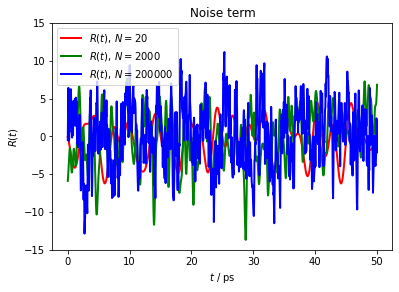

In [4]:
# Timeline
tmin    = 0
tmax    = 50
Nsteps  = 1000
tvalues = np.linspace( 0, tmax, Nsteps )
dt      = tvalues[1] - tvalues[0]
print(dt)

# Number of oscillators
Noscillators = np.array([20, 2000, 200000])        

R = np.zeros((Nsteps,3))

for i,N in enumerate(Noscillators):

    omega    = np.random.uniform( 0, 1, N ) * N ** a
    k_spring = ang_freqs(omega, N)
    m        = k_spring / omega ** 2
    
    # noise term
    xi     = np.random.normal(0, 1, N)
    # Q0     = 0
    # q0     = Q0 + xi * np.sqrt( 1 / beta / k_spring )

    eta    = np.random.normal(0, 1, N)
    # p0     = eta * np.sqrt(m / beta )
    
    for k,t in tqdm(enumerate(tvalues)):
        R[k,i] = noise_term( t, omega, k_spring, xi, eta )

W = sqrt( 2 * M * gamma / beta ) * np.random.normal(0,1,Nsteps)
    
fig, (ax1) = plt.subplots(1, 1,figsize=(12*in2cm, 8*in2cm))  
ax1.plot(tvalues, R[:,0], 'r-',    linewidth = 2,   label =r'$R(t),\, N=20$')
ax1.plot(tvalues, R[:,1], 'g-',    linewidth = 2,   label =r'$R(t),\, N=2000$')
ax1.plot(tvalues, R[:,2], 'b-',    linewidth = 2,   label =r'$R(t),\, N=200000$')

ax1.set_xlabel(r'$t$ / ps')
ax1.set_ylabel(r'$R(t)$')

ax1.set_title('Noise term')
ax1.legend()
ax1.set_ylim((-15, 15))

#ax2.plot(tvalues, W, 'k-',    linewidth = 2,   label ='White noise')

#ax2.set_xlabel(r'$t$ / ps')
#ax2.set_ylabel(r'$R(t)$')

#ax2.set_title('White noise')
#ax2.legend()
#ax2.set_ylim((-15, 15))
plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0.3, hspace=0.3)

#fig.savefig('figures/noise_term1.png', format='png', dpi=900, bbox_inches='tight')



In [5]:
# Generate and ensemble of random processes R(t)
Noscillators     = np.array([20, 2000, 200000])
Nreps = 10

R     = np.zeros((Nsteps, Nreps, 3))
K     = np.zeros((Nsteps, 3))

for j in range(3):
    
    N        = Noscillators[j]
    omega    = np.random.uniform( 0, 1, N ) * N ** a
    k_spring = ang_freqs(omega, N)
    m        = k_spring / omega ** 2
        
    for k,t in enumerate(tvalues):
        K[k,j] = memory_kernel1( t, omega, k_spring )
    
    for r in tqdm(range(Nreps)):

        # noise term
        xi     = np.random.normal(0, 1, N)
        eta    = np.random.normal(0, 1, N)

        for k,t in enumerate(tvalues):
            R[k,r,j] = noise_term( t, omega, k_spring, xi, eta )
        

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:30<00:00,  9.02s/it]


In [6]:
#R = sqrt( 2 * M * gamma / beta ) * np.random.normal(0,1,(Nsteps, Nreps))

# Autocorrelation
Atot  = np.zeros((Nsteps, 3))
Ntau  = np.arange(Nsteps)

for j in tqdm(range(3)):
    for r in range(Nreps):

        A = np.zeros(Nsteps)

        for t,tau in enumerate(Ntau):
            for k in range(Nsteps - tau):
                A[t] = A[t] + R[k,r,j] * R[k+tau,r,j]

            A[t] = A[t] / (Nsteps - tau)

        Atot[:,j] = Atot[:,j] + A
    
    Atot[:,j] = Atot[:,j] / Nreps 

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:08<00:00,  2.96s/it]


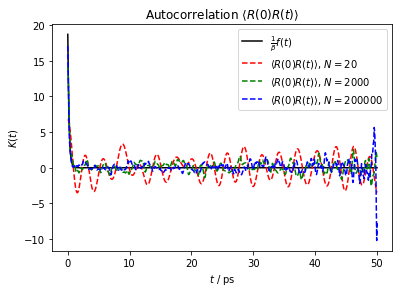

In [8]:
fig, ax = plt.subplots(1, 1,figsize=(12*in2cm, 8*in2cm))  

ax.plot(tvalues, f(tvalues) / beta, 'k',   label=r'$\frac{1}{\beta}f(t)$')
ax.plot(tvalues, Atot[:,0],  'r--' , label=r"$\langle R(0) R(t) \rangle, \, N=20$")
ax.plot(tvalues, Atot[:,1],  'g--' , label=r"$\langle R(0) R(t) \rangle, \, N=2000$")
ax.plot(tvalues, Atot[:,2],  'b--' , label=r"$\langle R(0) R(t) \rangle, \, N=200000$")

#ax.plot(tvalues, K[:,0],  'r-.' , label=r"$K(t), \, N=200$")
#ax.plot(tvalues, K[:,1],  'g-.' , label=r"$K(t), \, N=2000$")
#ax.plot(tvalues, K[:,2],  'b-.' , label=r"$K(t), \, N=20000$")

ax.set_xlabel(r'$t$ / ps')
ax.set_ylabel(r'$K(t)$')
ax.set_title(r'Autocorrelation $\langle R(0) R(t) \rangle$')
ax.legend()
plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0.3, hspace=0.3)
#fig.savefig('figures/noise_term2.png', format='png', dpi=900, bbox_inches='tight')

In [9]:
Nsteps

1000

In [13]:
np.mean(R[:,:,2])

0.1270530447727211

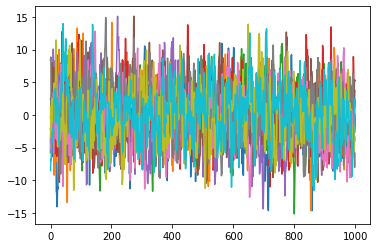

In [15]:
plt.plot(R[:,:,2])